# Prueba de evaluación 2, Parte 2

En esta segunda parte trabajaremos con información en XML. Concretamente, el gobierno británico nos ofrece datasets sobre eventos de tráfico:

https://data.gov.uk/dataset/live-traffic-information-from-the-highways-agency-road-network

Trabajaremos con los “Unplanned Events” que se proporcionan en un formato XML. Se puede descargar de esta URL:

http://hatrafficinfo.dft.gov.uk/feeds/datex/England/UnplannedEvent/content.xml

Concretamente, contiene un conjunto de situaciones (“situation”) y dentro de la descripción de las situaciones, nos interesa el impacto (“impact”). 

Investiga el impacto de los eventos no planificados en las variables que aporten algo de información. 

Por ejemplo, la variable “capacityRemaining” indica la capacidad de la vía que la situación dejó sin afectar, y en ocasiones indica obstrucción total (valor 0.0) pero en otros casos sólo parcial. Estudia descriptivamente al menos 3 de las variables, sean numéricas o categóricas, dentro de las que describen el impacto solamente.

In [1]:
%ls -l *.xml # veo los ficheros xml

 El volumen de la unidad D es DATA
 El n£mero de serie del volumen es: 7A3A-0B5D

 Directorio de D:\EntornosDataSciencePython\Entregable\Envio2


 Directorio de D:\EntornosDataSciencePython\Entregable\Envio2

23/10/2016  18:10            13.773 UnplannedEvents.xml
               1 archivos         13.773 bytes
               0 dirs  932.197.728.256 bytes libres


In [6]:
from lxml import objectify
parsed = objectify.parse('UnplannedEvents.xml') # se parsea el fichero para poder construir data frame
root = parsed.getroot()
print root.tag
print root.attrib
print root.countchildren()

{http://datex2.eu/schema/1_0/1_0}d2LogicalModel
{'modelBaseVersion': '1.0'}
2


In [77]:
# Obtengo los atributos interesantes para el análisis

situation=[]
probabilityOfOccurrence=[]
environmentalObstructionType = []
impactOnTraffic =[]
capacityRemaining=[]
numberOfLanesRestricted=[]
numberOfOperationalLanes =[]
originalNumberOfLanes = []
trafficRestrictionType = []
delayTimeValue = []



for row in root.payloadPublication.situation:
    
    situation.append(row.get('id'))
    probabilityOfOccurrence.append(row.situationRecord.probabilityOfOccurrence.text)
    impactOnTraffic.append(row.situationRecord.impact.impactOnTraffic.text)
    capacityRemaining.append(float(row.situationRecord.impact.impactDetails.capacityRemaining.text))
    numberOfLanesRestricted.append(int(row.situationRecord.impact.impactDetails.numberOfLanesRestricted.text))
    numberOfOperationalLanes.append(int(row.situationRecord.impact.impactDetails.numberOfOperationalLanes.text))
    originalNumberOfLanes.append(int(row.situationRecord.impact.impactDetails.originalNumberOfLanes.text))
    trafficRestrictionType.append( row.situationRecord.impact.impactDetails.trafficRestrictionType.text)
    delayTimeValue.append(float(row.situationRecord.impact.delays.delayTimeValue.text))

In [78]:
# construyo el data frame

import pandas as pd

data = pd.DataFrame()
data['situation'] = situation
data['probabilityOfOccurrence'] = probabilityOfOccurrence
data['impactOnTraffic'] = impactOnTraffic
data['capacityRemaining'] = capacityRemaining
data['numberOfLanesRestricted'] = numberOfLanesRestricted
data['numberOfOperationalLanes'] = numberOfOperationalLanes
data['originalNumberOfLanes'] = originalNumberOfLanes
data['trafficRestrictionType'] = trafficRestrictionType
data['delayTimeValue'] = delayTimeValue


data

,situation,probabilityOfOccurrence,impactOnTraffic,capacityRemaining,numberOfLanesRestricted,numberOfOperationalLanes,originalNumberOfLanes,trafficRestrictionType,delayTimeValue
0,GUID732336731,certain,heavy,75.0,1,3,4,carriagewayPartiallyObstructed,600.0
1,GUID732889125,certain,impossible,0.0,2,0,2,carriagewayBlocked,900.0
2,GUID732957845,certain,impossible,0.0,1,0,1,carriagewayBlocked,600.0
3,GUID733038589,certain,impossible,0.0,1,0,1,carriagewayBlocked,0.0
4,GUID733038591,certain,impossible,0.0,1,0,1,carriagewayBlocked,0.0
5,GUID733043648,certain,freeFlow,33.0,2,1,3,carriagewayPartiallyObstructed,0.0


Voy a analizar el número medio de carriles operativos y cerrados agrupando por impacto en el tráfico.

In [79]:
impactOnTraffic = data.groupby('impactOnTraffic').agg({'originalNumberOfLanes': lambda x: x.mean(), 
                                          'numberOfOperationalLanes': lambda x: x.mean(),
                                          'numberOfLanesRestricted': lambda x: x.mean()})

impactOnTraffic

,numberOfOperationalLanes,originalNumberOfLanes,numberOfLanesRestricted
impactOnTraffic,,,
freeFlow,1,3.00,2.00
heavy,3,4.00,1.00
impossible,0,1.25,1.25


Observo que en el caso de free floow en la muestra había en media un carril disponible (aunque solo tenemos una observación, por lo que puede no ser representativa).
En caso de gran impacto en trafico (heavy) habia 3 carriles disponibles (siendo 4 originalmente).
En caso del mayor impacto (impossible)el trafico se ha cerrado totalmente (0 carriles disponibles).

In [80]:
# Analizando la capacidad residual:
capacity = data.groupby('impactOnTraffic').agg({'capacityRemaining': lambda x: x.mean()})

capacity

,capacityRemaining
impactOnTraffic,
freeFlow,33.0
heavy,75.0
impossible,0.0


Observamos que cuanto mayor impacto en el trafico, más disminuye la capacidad residual.

In [81]:
#Analizando el retraso:
delay = data.groupby('impactOnTraffic').agg({'delayTimeValue': lambda x: x.mean()})

delay

,delayTimeValue
impactOnTraffic,
freeFlow,0.0
heavy,600.0
impossible,375.0


Observamos que en caso de free floow no había ningun retraso. Sin embargo, el retraso fue mayor en media cuando el impacto se clasificaba como "havy" que el retraso correspondiente a las observaciones clasificadas como "imposible". 

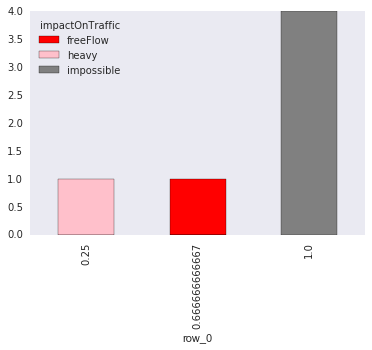

In [82]:
%matplotlib inline

import matplotlib.pyplot as plt

# el gráfico representa el porcentaje de los carriles restringidos clasificando por impacto en tráfico.

graf = pd.crosstab(data.numberOfLanesRestricted/data.originalNumberOfLanes, data.impactOnTraffic)
graf.plot(kind='bar', stacked=True, color=['red','pink','grey'], grid=False)

Observamos que en el caso de immacto "imposibble" el 100% de los carriles han sido inabilitados.
En caso de free flow han sido 66% y en caso de impacto "heavy" - un 25%.

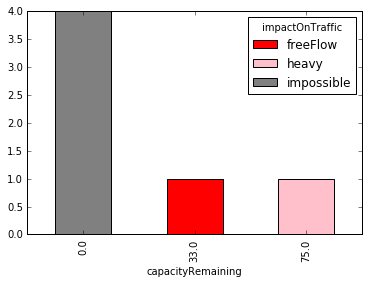

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

# El gráfico representa el porcentaje de los carriles disponibles clasificando por impacto en tráfico. 
#Las conclusiones con coherentes con el gráfico anterior

graf = pd.crosstab(data.capacityRemaining, data.impactOnTraffic)
graf.plot(kind='bar', stacked=True, color=['red','pink','grey'], grid=False)

In [69]:
# Analizo las correlaciones entre las variables
data.corr(method='pearson')

,capacityRemaining,numberOfLanesRestricted,numberOfOperationalLanes,originalNumberOfLanes,delayTimeValue
capacityRemaining,1.000000,-0.037618,0.994496,0.936800,0.116920
numberOfLanesRestricted,-0.037618,1.000000,-0.106600,0.306186,0.194257
numberOfOperationalLanes,0.994496,-0.106600,1.000000,0.913908,0.165663
originalNumberOfLanes,0.936800,0.306186,0.913908,1.000000,0.237915
delayTimeValue,0.116920,0.194257,0.165663,0.237915,1.000000


Observamos correlación negativa entre la capacidad residual (capacity remaining) y el número de carriles restringidos.
La capacidad residual está positivamente correlacionada con el número de carriles que había originalmente: cuantos más carriles en el momento inicial, más capacidad residual.
El retraso no parece tener mucha correlación con el número de carriles disponibles.

Voy a ver relacion entre el retraso y los carriles disponibles.

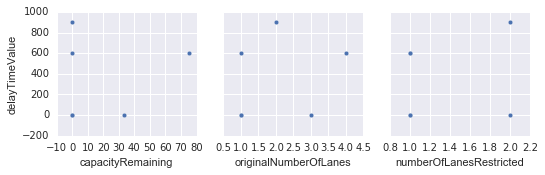

In [83]:
sns.pairplot(data=data,
             x_vars=['capacityRemaining', 'originalNumberOfLanes', 'numberOfLanesRestricted'],     
             y_vars=['delayTimeValue'] )

No se observa una relación